In [13]:
import numpy as np
import pytictoc 
from keras.losses import MeanAbsoluteError
import tensorflow as tf
mae = MeanAbsoluteError()

timer = pytictoc.TicToc()
d = np.random.uniform(0, 5, size=(5, 100_000))
e = np.random.uniform(0, 5, size=(5, 100_000))

((d.astype(np.int32) - 127.5) / 127.5).dtype
batch_size = 4 * 256 * 256 * 3

weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

timer.tic()
for _ in range(1000):
    size = len(d)
    loss2 = mae(d, e, sample_weight=weights) * size
timer.toc()

timer.tic()
for _ in range(1000):
    loss1 = 0
    for i in range(len(d)):
        loss1 += mae(d[i], e[i]) * weights[i]
timer.toc()



print(loss1, loss2)

Elapsed time is 2.064728 seconds.
Elapsed time is 7.777587 seconds.
tf.Tensor(2.4439254816837748, shape=(), dtype=float64) tf.Tensor(2.4439254816837748, shape=(), dtype=float64)


In [19]:
"""
Double Discriminator GAN architecture
@author: Adrian Kucharski
"""
import datetime
import math
import os
from pathlib import Path
from typing import List, NamedTuple, Tuple, Union
import inspect
import numpy as np
from pyparsing import str_type
import tensorflow as tf
from skimage import io
from keras import Model, Sequential, initializers
from keras.layers import (
    BatchNormalization,
    GaussianDropout,
    Concatenate,
    Conv2D,
    UpSampling2D,
    Dropout,
    Input,
    LeakyReLU,
    ReLU,
    MaxPooling2D,
    Conv2DTranspose,
    Dense,
    Flatten,
    Activation,
    Reshape,
    Layer
)
from keras.losses import BinaryCrossentropy, MeanAbsoluteError, Hinge
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, LambdaCallback, ModelCheckpoint
from tqdm import tqdm
from dataset import DataIterator
import keras.backend as K
import pytictoc

class Noise(Layer):
    def __init__(self, size: List[int]):
        super().__init__()
        self.size = size

    def call(self, inputs, *args, **kwargs):
        return tf.random.normal(shape=(tf.shape(inputs)[0], *self.size))

    def get_config(self):
        return {"size": self.size}
    
def _generator_model(input_size):
    kernels = 4
    depth = 6
    nc = 256
    fl = 64
    sd = input_size[0] // 2 ** depth
    
    H = h = Input(input_size, name="mask")
    z = Noise((256,))(h)
    n = Dense(sd * sd * nc)(z)
    x = Reshape((sd, sd, nc))(n)

    for p in reversed(range(1, depth + 1)):
        m = tf.image.resize(h, x.shape[1:3], method='nearest')
        x = Concatenate()([x, m])
        x = Conv2D(fl * p, kernels, padding='same')(x)
        x = Conv2DTranspose(fl * p, kernels, strides=2, padding='same')(x)
        
    x = Conv2D(3, 3, padding='same', activation='tanh')(x)
    return Model(inputs=H, outputs=x)
        
_generator_model((256, 256, 3)).output_shape

(None, 256, 256, 3)

: 

(5, 256, 256, 1) (5, 256, 256, 3)
0.0 1.0
-1.0 1.0


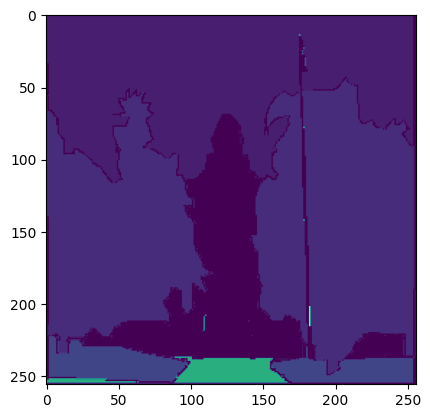

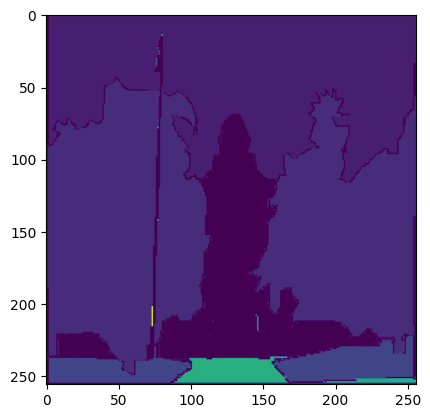

In [10]:
from matplotlib import pyplot as plt
from dataset import DataIterator, load_dataset
from keras import Sequential
from keras.layers import (
    Conv2D,
    Input,
)
import numpy as np

dataset = load_dataset('data/ADE20K/24_classes.npy', 'data/ADE20K/images.npy')
masks, images = dataset

# masks.shape -> 90000, 256, 256, 1 -> (0, 24)   | uint8
# images.shape -> 90000, 256, 256, 3 -> (0, 255) | uint8

model = Sequential(
    [
        Input((256, 256, 25)),
        Conv2D(8, 4, padding='same'),
        Conv2D(1, 4, padding='same', activation='tanh')
    ]
)
model.compile(loss='mse')

# as_categorical -> masks.shape -> 90000, 256, 256, 1 -> ..., 25 -> one hot
#
di = DataIterator(dataset, 5, as_categorical=False)
# di.on_epoch_end()
for epoch in range(5):
    for _mask, _image in di:
        print(_mask.shape, _image.shape)
        print(_mask.min(), _mask.max())
        print(_image.min(), _image.max())
        plt.imshow(_mask[0])
        plt.show()
        m = np.flip(_mask, axis=2)
        plt.imshow(m[0])
        plt.show()
        # model.train_on_batch(_mask, _image)
        break
    di.on_epoch_end()
    break

# PatchGAN - Mikołaj
# GAUGAN - Łukasz
# Double Discriminator PatchGAN - Adrian

1. Skrypt dataset
2. 157 linijka na True
3. Podać właściwy classes_path
4. uruchomić skrypt

1. Logowanie kodu modelu który uczymy -> inspect.getsource(GAN_Training) -> str
2. Wyświetlanie tego co produkuje GAN co pewien krok/każdą epokę
3. GAN produkuje czarne/zielone/czerwone obraz -> coś jest nie tak z modelem (za duży, za mały, generator się uczy za szybko, dyskryminator się uczy za wolno)
4. learning rate -> dyskryminator powinien mieć większy lr niż generator (uczony przez dyskryminato) np.: D: 4e-4, G: 1e-4 


In [3]:
from model.srgan import generator
from model import resolve_single
from skimage import io 

model = generator()
model.load_weights('srgan_model/gan_generator.h5')
lr = io.imread(r'data\ADE20K\images_256\ADE_train_00000004.png')
print(lr.min(), lr.max())
sr = resolve_single(model, lr)

0 255


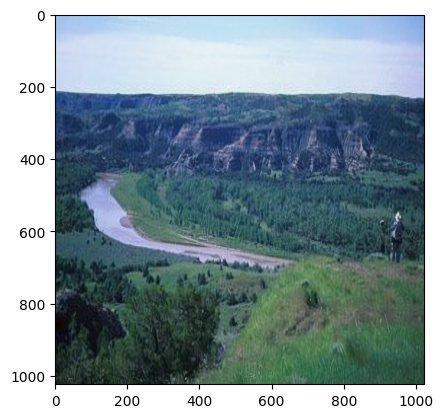

In [4]:
import matplotlib.pyplot as plt
plt.imshow(sr)